In [1]:
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
import mlflow
import mlflow.spark
import pandas as pd
import os
import numpy as np
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
import findspark
findspark.init("/opt/manual/spark/")

spark = (SparkSession.builder
         .appName("Spark Churn Prediction with Random Forest Model")
         .master("yarn")
         .getOrCreate())

/home/train/venvspark/lib/python3.6/site-packages/pyspark/sql/context.py:77: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  DeprecationWarning)


In [4]:
df = (spark
      .read
      .format("csv")
      .option("inferSchema",True)
      .option("header", True)
      .option("sep",",")
      .load("hdfs://localhost:9000/user/train/datasets/churn.csv"))

In [5]:
df.limit(10).toPandas()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [6]:
df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [7]:
# Missing Value & hidden missing value Control

for(col_name, col_type) in zip(df.columns, df.dtypes):
    null_count = df.filter( (F.col(col_name).isNull()) | (F.col(col_name) == "")).count()
    if(  null_count > 0 ):
        print("{} {} type has {} null values".format(col_name, col_type[1], null_count))

In [8]:
df.select("Exited").groupBy("Exited").count().show()

+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



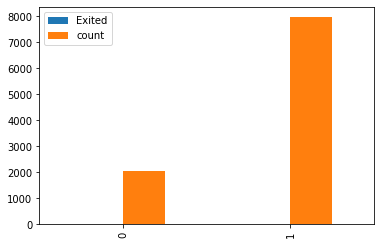

In [9]:
df.select("Exited").groupBy("Exited").count().toPandas().plot(kind='bar');

In [10]:
mlflow.set_tracking_uri('http://localhost:5000/')
print("mlflow tracking_uri: " + mlflow.tracking.get_tracking_uri())

mlflow tracking_uri: http://localhost:5000/


In [11]:
mlflow.set_experiment("Spark Churn Prediction with Random Forest Model1")

In [12]:
categoric_cols = []
numeric_cols = []
discarted_cols = []
label_col = []

# column seperation
for col_name in df.dtypes:
    if (col_name[0] not in []):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else:
            numeric_cols.append(col_name[0])

In [13]:
for col_name in categoric_cols:
    df.groupBy(col_name).agg(F.count("*").alias("TotalCount")).orderBy(F.desc("TotalCount")).show()

+--------+----------+
| Surname|TotalCount|
+--------+----------+
|   Smith|        32|
|  Martin|        29|
|   Scott|        29|
|  Walker|        28|
|   Brown|        26|
|    Shih|        25|
|     Yeh|        25|
|Genovese|        25|
|  Wright|        24|
| Maclean|        24|
|  Wilson|        23|
|      Ma|        23|
| Fanucci|        23|
|   White|        23|
|     Chu|        22|
|   Moore|        22|
|    Wang|        22|
|      Lu|        22|
| Johnson|        22|
|McGregor|        21|
+--------+----------+
only showing top 20 rows

+---------+----------+
|Geography|TotalCount|
+---------+----------+
|   France|      5014|
|  Germany|      2509|
|    Spain|      2477|
+---------+----------+

+------+----------+
|Gender|TotalCount|
+------+----------+
|  Male|      5457|
|Female|      4543|
+------+----------+



In [14]:
# column seperation after analysis
categoric_cols = []
numeric_cols = []
# Why we discard these? Because they have high cardinality. In other words they have too many distinct categories
# Adding them to model will not do good if not too bad.
discarted_cols = ['RowNumber', 'CustomerId', 'Surname']
label_col = ['Exited']

In [15]:
for col_name in df.dtypes:
    if (col_name[0] not in discarted_cols+label_col):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [16]:
print(numeric_cols)
print(len(numeric_cols))


['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
8


In [17]:
print(discarted_cols+label_col)
print(len(discarted_cols+label_col))

['RowNumber', 'CustomerId', 'Surname', 'Exited']
4


In [18]:
if len(df.columns) == (len(categoric_cols)+len(numeric_cols)+len(discarted_cols+label_col)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


In [19]:
# Here we count the distinct categories in categoric columns. If there is more than two,
# we will add those to to_be_onehotencoded_cols list If there is just 2 we don't need to use onehotencoder
# So if distinct category gt 2 we have to add it to_be_onehotencoded_cols list
to_be_onehotencoded_cols = []

for col_name in categoric_cols:
    count = df.select(col_name).distinct().count()
    if count > 2:
        to_be_onehotencoded_cols.append(col_name)
    print("{} has {} distinct category.".format(col_name, count))

Geography has 3 distinct category.
Gender has 2 distinct category.


In [20]:
print(to_be_onehotencoded_cols)

['Geography']


In [21]:
# Will hold stringIndexer objects and column names
my_dict = {}

# Will collect StringIndexer ojects
string_indexer_objs = []

# Will collect StringIndexer output colnames
string_indexer_output_names = []

# Will collect OneHotEncoder output colnames
ohe_col_input_names = []
ohe_col_output_names = []

for col_name in categoric_cols:
    my_dict[col_name+"_indexobj"] = StringIndexer() \
    .setHandleInvalid('skip') \
    .setInputCol(col_name) \
    .setOutputCol(col_name+"_indexed")
    
    string_indexer_objs.append(my_dict.get(col_name+"_indexobj"))
    string_indexer_output_names.append(col_name+"_indexed")
    if col_name in to_be_onehotencoded_cols:
        ohe_col_input_names.append(col_name+"_indexed")
        ohe_col_output_names.append(col_name+"_ohe")

In [22]:
print(string_indexer_objs)
print(len(string_indexer_objs))

[StringIndexer_40ba617d6ff7, StringIndexer_8198bd2c0d3a]
2


In [23]:
print(string_indexer_output_names)
print(len(string_indexer_output_names))

['Geography_indexed', 'Gender_indexed']
2


In [24]:
print(ohe_col_input_names)
print(len(ohe_col_input_names))

['Geography_indexed']
1


In [25]:
print(ohe_col_output_names)
print(len(ohe_col_output_names))

['Geography_ohe']
1


In [26]:
encoder = OneHotEncoder() \
.setInputCols(ohe_col_input_names) \
.setOutputCols(ohe_col_output_names)

In [27]:
# We have to exclude onehotencoded categoric cols from stringIndexer cols
string_indexer_col_names_ohe_exluded = list(set(string_indexer_output_names).difference(set(ohe_col_input_names)))
string_indexer_col_names_ohe_exluded

['Gender_indexed']

In [28]:
if len(categoric_cols) == (len(string_indexer_col_names_ohe_exluded)+len(ohe_col_output_names)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


In [29]:
#df = df.withColumnRenamed("Exited","label")

In [30]:
df.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [31]:
assembler = VectorAssembler().setHandleInvalid("skip") \
.setInputCols(numeric_cols+string_indexer_col_names_ohe_exluded+ohe_col_output_names) \
.setOutputCol('assembled_features')

In [32]:
label_indexer = StringIndexer().setHandleInvalid("skip") \
.setInputCol(label_col[0]) \
.setOutputCol("label")

In [33]:
rf_c = RandomForestClassifier(featuresCol='assembled_features', labelCol='label',predictionCol='prediction')

In [34]:
pipeline = Pipeline().setStages(string_indexer_objs+[encoder, assembler, label_indexer, rf_c])

In [35]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(rf_c.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf_c.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .addGrid(rf_c.minInstancesPerNode , [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [36]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [37]:
(trainData, testData) = df.randomSplit([0.8, 0.2])

In [38]:
print(trainData.count())
print(testData.count())

8002
1998


In [ ]:
crossval = crossval.fit(trainData)

In [39]:
df_glb = spark.createDataFrame

In [123]:
pred_schema = "rowid int, customerid int, label float, prediction float"

In [135]:
# Postgresql connection string
jdbcUrl = "jdbc:postgresql://localhost/traindb?user=train&password=Ankara06"

In [198]:
def write_to_postgresql_sink(df, batchId):
    df_postgres = df.select("customerid", "label", "prediction")
    df_postgres.show(5)
    
    # write postgresql
    df_postgres.write.jdbc(url=jdbcUrl,
                  table="churn_pred_results",
                  mode="append",
                  properties={"driver": 'org.postgresql.Driver'})
    
    return df_postgres

In [193]:
CheckpointDir = "file:///home/train/stream_to_postgres_checkpoint"

In [206]:
with mlflow.start_run(run_name="spark-ChurnPrediction-random-forest") as run:
    # Log params:
    mlflow.log_param("num_trees", rf_c.getNumTrees())
    mlflow.log_param("max_depth", rf_c.getMaxDepth())
    mlflow.log_param("max_bins", rf_c.getMaxBins())

    # Log model
    pipelineModel = pipeline.fit(trainData)
    mlflow.spark.log_model(pipelineModel, "model")

    # Log metrics: RMSE and R2
    predDF = pipelineModel.transform(testData)
    df_glb = predDF
    classificationEvaluator = BinaryClassificationEvaluator(labelCol="Exited")
    accuracy = classificationEvaluator.evaluate(predDF)
    mlflow.log_metrics({"accuracy": accuracy})

    # Log model register as version 1
    mlflow.spark.log_model(
        spark_model=pipelineModel,
        artifact_path="spark-randomforest",
        registered_model_name="spark-random-forest-class-model"
    )
    # After run you can go ui and see model http://localhost:5000/#/models
    # Log artifact: feature importance scores
    rfModel = pipelineModel.stages[-1]
    pandasDF = (pd.DataFrame(list(zip(assembler.getInputCols(), rfModel.featureImportances)),
                             columns=["feature", "importance"]).sort_values(by="importance", ascending=False))

    # First write to local filesystem, then tell MLflow where to find that file
    pandasDF.to_csv("churn-prediction-feature-importance.csv", index=False)
    mlflow.log_artifact("churn-prediction-feature-importance.csv")

    df_postgres = df_glb.select("customerid", "label", "Prediction")
    df_postgres.show(5)
    
    # write postgresql
    df_postgres.write.jdbc(url=jdbcUrl,
                  table="churn_pred_results",
                  mode="append",
                  properties={"driver": 'org.postgresql.Driver'})
    
    
    # write predictions to csv
#    df_glb.select('customerid', 'label', 'prediction').toPandas().to_csv('/home/train/PROJECT/prediction_results.csv')
    
    #readstream data
#    lines = (spark
#         .readStream.format("csv")
#         .schema(pred_schema)
#         .option("header", True)
#         .load("file:///home/train/PROJECT"))
    
    # start streaming
#    streamingQuery = (lines
#                  .writeStream
#                  .foreachBatch(write_to_postgresql_sink)
#                  .option("checkpointLocation", CheckpointDir)
#                  .start())
    #
#    #streamingQuery.awaitTermination()

Registered model 'spark-random-forest-class-model' already exists. Creating a new version of this model...
2021/03/17 20:15:59 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: spark-random-forest-class-model, version 95
Created version '95' of model 'spark-random-forest-class-model'.


+----------+-----+----------+
|customerid|label|Prediction|
+----------+-----+----------+
|  15600882|  0.0|       0.0|
|  15788218|  0.0|       0.0|
|  15661507|  0.0|       0.0|
|  15568982|  0.0|       0.0|
|  15725737|  0.0|       0.0|
+----------+-----+----------+
only showing top 5 rows



In [195]:
df_glb.select('CustomerId', 'Exited', 'Prediction').toPandas().to_csv('mycsv.csv')

+----------+-----+----------+
|customerid|label|prediction|
+----------+-----+----------+
|  15600882|  0.0|       0.0|
|  15788218|  0.0|       0.0|
|  15661507|  0.0|       0.0|
|  15568982|  0.0|       0.0|
|  15725737|  0.0|       0.0|
+----------+-----+----------+
only showing top 5 rows



In [108]:
df_glb.select('CustomerId', 'label', 'prediction').limit(5).toPandas()

,CustomerId,label,prediction
0,15600882,0.0,0.0
1,15788218,0.0,0.0
2,15661507,0.0,0.0
3,15568982,0.0,0.0
4,15725737,0.0,0.0


In [203]:
df_glb.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Geography_indexed',
 'Gender_indexed',
 'Geography_ohe',
 'assembled_features',
 'label',
 'rawPrediction',
 'probability',
 'prediction']